In [1]:
%matplotlib inline


from typing import Optional, Union

import os
import sys

import torch
import torchvision
from torch import Tensor
import torch.nn.functional as F
from torchvision.ops import boxes as box_ops
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)
np.random.seed(0)

In [2]:
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('device ', device)

main_dirpath='D:/data/'
tensor_dirpath=os.path.join(main_dirpath, 'mask_rcnn')
original_inputs=torch.load(os.path.join(tensor_dirpath, 'part-backbonefpn-orig_input.pt'), map_location=device, weights_only=True)
tfm_inputs=torch.load(os.path.join(tensor_dirpath, 'part-backbonefpn-transform.pt'), map_location=device, weights_only=False)

device  cpu


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.108192..2.6400003].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.110678..2.6400003].


0 torch.Size([3, 832, 1056]) torch.float32 -2.108191967010498 2.640000343322754
1 torch.Size([3, 832, 1056]) torch.float32 -2.11067795753479 2.640000343322754


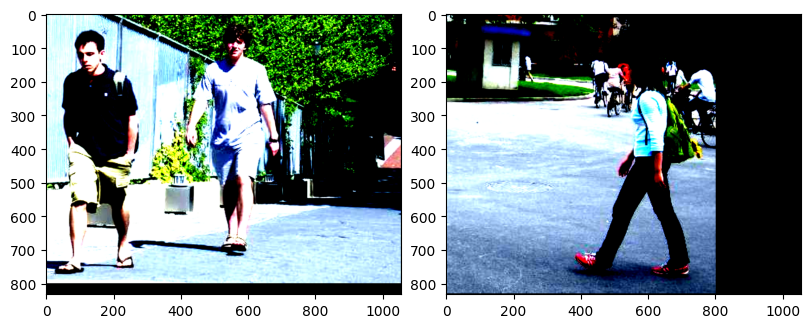

In [3]:
fig, axes=plt.subplots(1,2,figsize=(8,3))
for i, im in enumerate(tfm_inputs['tfm_images'].tensors):
    print(i, im.shape, im.dtype, im.min().item(), im.max().item())
    axes[i].imshow(im.permute(1,2,0).numpy())
plt.tight_layout(pad=0,w_pad=0,h_pad=0)

In [4]:
num_classes=2
# load an instance segmentation model pre-trained on COCO
model=torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights='DEFAULT', rpn_pre_nms_top_n_train=800,
        rpn_pre_nms_top_n_test=500,  rpn_post_nms_top_n_train=800,  rpn_post_nms_top_n_test=500, box_detections_per_img=100,
        box_batch_size_per_image =400, rpn_batch_size_per_image=100)
# get number of input features for the classifier
in_features=model.roi_heads.box_predictor.cls_score.in_features
print('the number of inpute features for classifiers ', in_features)
# replace the pre-trained head with a new one
model.roi_heads.box_predictor=FastRCNNPredictor(in_features,  num_classes)

# get the number of input features for the mask classifiers
in_features_mask=model.roi_heads.mask_predictor.conv5_mask.in_channels
print('the number of input features for mask ', in_features_mask)
hidden_layer=256
# and replace the mask predictor with a new one
model.roi_heads.mask_predictor=MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

# move model to the right device
model.to(device);

the number of inpute features for classifiers  1024
the number of input features for mask  256


[`RPN forward`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/rpn.py)

In [5]:
features=tfm_inputs['out']
images=tfm_inputs['tfm_images']
targets=tfm_inputs['tmf_targets']
print('features ', {k:(v.shape, v.min().item(), v.max().item()) for k, v in features.items()})

# RPN uses all feature maps that are available
features=list(features.values())
# list of N tensors, where N is batch size, each is the concatenation of anchors for all feature maps, i.e., each is LHWAx4 
anchors=model.rpn.anchor_generator(images, features) 
print('base anchors')
for a in anchors:
    print(a.shape, a.min(dim=0).values.tolist(), a.max(dim=0).values.tolist())

features  {'0': (torch.Size([2, 256, 208, 264]), -2.1181082725524902, 2.168463945388794), '1': (torch.Size([2, 256, 104, 132]), -1.646379828453064, 1.6166932582855225), '2': (torch.Size([2, 256, 52, 66]), -1.5383321046829224, 1.5961196422576904), '3': (torch.Size([2, 256, 26, 33]), -1.5852569341659546, 1.9735815525054932), 'pool': (torch.Size([2, 256, 13, 17]), -1.4886037111282349, 1.6521222591400146)}
base anchors
torch.Size([219453, 4]) [-362.0, -362.0, 11.0, 11.0] [1041.0, 817.0, 1354.0, 1130.0]
torch.Size([219453, 4]) [-362.0, -362.0, 11.0, 11.0] [1041.0, 817.0, 1354.0, 1130.0]


In [6]:
#  objectness, pred_bbox_deltas = self.head(features)
# line 71 https://github.com/pytorch/vision/blob/main/torchvision/models/detection/rpn.py
objectness, pred_bbox_deltas=[], []
for i, feature in enumerate(features):
    print(i, '-'*50)
    t=model.rpn.head.conv(feature)
    objectness.append(model.rpn.head.cls_logits(t))
    pred_bbox_deltas.append(model.rpn.head.bbox_pred(t))
    print('t', t.shape)
    print('objectness ', objectness[-1].shape, objectness[-1].min().item(),
         objectness[-1].max().item())
    print('pred_bbox_deltas ',pred_bbox_deltas[-1].shape, pred_bbox_deltas[-1].min().item(),
         pred_bbox_deltas[-1].max().item())

0 --------------------------------------------------
t torch.Size([2, 256, 208, 264])
objectness  torch.Size([2, 3, 208, 264]) -20.947940826416016 6.6456828117370605
pred_bbox_deltas  torch.Size([2, 12, 208, 264]) -2.640944004058838 2.4117095470428467
1 --------------------------------------------------
t torch.Size([2, 256, 104, 132])
objectness  torch.Size([2, 3, 104, 132]) -23.3656005859375 9.424311637878418
pred_bbox_deltas  torch.Size([2, 12, 104, 132]) -1.9820599555969238 2.097860097885132
2 --------------------------------------------------
t torch.Size([2, 256, 52, 66])
objectness  torch.Size([2, 3, 52, 66]) -25.335609436035156 8.648380279541016
pred_bbox_deltas  torch.Size([2, 12, 52, 66]) -1.5455602407455444 1.6299505233764648
3 --------------------------------------------------
t torch.Size([2, 256, 26, 33])
objectness  torch.Size([2, 3, 26, 33]) -25.462982177734375 7.077332496643066
pred_bbox_deltas  torch.Size([2, 12, 26, 33]) -1.5048316717147827 1.0456032752990723
4 -----

In [7]:
def concat_box_prediction_layers(box_cls:list[Tensor], box_regression: list[Tensor])->tuple[Tensor,Tensor]:
    '''
    Args:
        box_cls (list[Tensor]): containing objectness score tensors, each of size NxAxCxHxW where A is the number of anchors
        box_regression (list[Tensor]): containing tensors to adjust anchors for bounding box, each of size NxAx4xHxW where A is the number of anchors
    Returns:
        box_cls (Tensor): NHWAxC objectness score per box, where C=1 since this is a binary score per box (i.e., whether a box contains an object)
        box_regression (Tensor): NHWAx4 box delta
    '''
    def permute_and_flatten(layer: Tensor, N: int, A: int, C: int, H: int, W:int)->Tensor:
        layer=layer.view(N,-1,C,H,W)
        layer=layer.permute(0,3,4,1,2) # NxHxWxAxC
        layer=layer.reshape(N,-1,C) # NxHWAxC
        return layer
        
    box_cls_flattened, box_regression_flattened=[],[]
    # for each feature level, permute the outputs to make them be in the same format as the labels. Note that the labels are
    # computed for all feature levels concatenated, so we keep the same representation for the objectness and the box 
    # regression
    for box_cls_per_level, box_regression_per_level in zip(box_cls, box_regression):
        # N is batch size, A is the number of anchors, C=1 is the binary classification score for each anchor
        # Note: the number of anchors determined by sizes and aspect_ratios into the AnchorGenerator
        # https://github.com/pytorch/vision/blob/main/torchvision/models/detection/anchor_utils.py
        N, AxC, H, W=box_cls_per_level.shape 
        Ax4=box_regression_per_level.shape[1]
        A=Ax4//4
        C=AxC//A
        box_cls_per_level=permute_and_flatten(box_cls_per_level,N, A, C, H, W)
        box_cls_flattened.append(box_cls_per_level)

        box_regression_per_level=permute_and_flatten(box_regression_per_level, N, A, 4, H,W)
        box_regression_flattened.append(box_regression_per_level)
    # concatenate on the first dimension (representing the feature levels), to take into account the way
    # the labels were generated (with all feature maps being concatenated as well)
    print('box_cls_flattened ', [c.shape for c in box_cls_flattened])
    print('\ttorch.cat(box_cls_flattened, dim=1) ', torch.cat(box_cls_flattened, dim=1).shape)
    box_cls=torch.cat(box_cls_flattened, dim=1).reshape(-1, 1) # C=1 for binary score per anchors
    print('box_regression_flattened ', [r.shape for r in box_regression_flattened])
    print('\ttorch.cat(box_regression_flattened, dim=1) ', torch.cat(box_regression_flattened, dim=1).shape)
    box_regression=torch.cat(box_regression_flattened, dim=1).reshape(-1, 4)
    return box_cls, box_regression

In [8]:
num_images=len(anchors)
num_anchors_per_level=[np.prod(o.shape[1:]) for o in objectness]
print(num_images, num_anchors_per_level)
objectness, pred_bbox_deltas=concat_box_prediction_layers(objectness, pred_bbox_deltas)
print('objectness ', objectness.shape, objectness.min().item(), objectness.max().item())
print('pred_bbox_deltas ', pred_bbox_deltas.shape, pred_bbox_deltas.min(0).values.tolist(), pred_bbox_deltas.max(0).values.tolist())

2 [np.int64(164736), np.int64(41184), np.int64(10296), np.int64(2574), np.int64(663)]
box_cls_flattened  [torch.Size([2, 164736, 1]), torch.Size([2, 41184, 1]), torch.Size([2, 10296, 1]), torch.Size([2, 2574, 1]), torch.Size([2, 663, 1])]
	torch.cat(box_cls_flattened, dim=1)  torch.Size([2, 219453, 1])
box_regression_flattened  [torch.Size([2, 164736, 4]), torch.Size([2, 41184, 4]), torch.Size([2, 10296, 4]), torch.Size([2, 2574, 4]), torch.Size([2, 663, 4])]
	torch.cat(box_regression_flattened, dim=1)  torch.Size([2, 219453, 4])
objectness  torch.Size([438906, 1]) -25.462982177734375 9.424311637878418
pred_bbox_deltas  torch.Size([438906, 4]) [-1.1385107040405273, -1.6692206859588623, -2.640944004058838, -2.4879403114318848] [0.9486969709396362, 1.9546760320663452, 2.2222673892974854, 2.4117095470428467]


In [9]:
# apply pred_bbox_deltas to anchors to obtain the decoded proposals. Note that we detach the deltas
# because we do not backprop through the proposals
# proposals = self.box_coder.decode(pred_bbox_deltas.detach(), anchors) https://github.com/pytorch/vision/blob/main/torchvision/models/detection/_utils.py
def decode(box_coder, rel_codes: Tensor, boxes: list[Tensor]):
    '''
    From a set of original boxes and encoded relative box offsets, get the decoded boxes
    Args:
        box_coder (torchvision.models.detection.BoxCoder)
        rel_codes (Tensor): encoded boxes
        boxes (Tensor): reference boxes
    Returns:
        pred_boxes (Tensor): NHWAx1x4 adjusted box locations
    '''
    assert isinstance(boxes, (list, tuple)), f'Expect boxes to be list or tuple but got {type(boxes)}'
    assert isinstance(rel_codes, torch.Tensor), f'Expect rel_codes to be Tensor but got {type(rel_codes)}'
    # total number of boxes
    box_sum=np.sum([b.shape[0] for b in boxes])
    concat_boxes=torch.cat(boxes, dim=0)
    if box_sum>0: rel_codes=rel_codes.reshape(box_sum,-1)
    pred_boxes=decode_single(rel_codes=rel_codes, boxes=concat_boxes, weights=box_coder.weights, bbox_xform_clip=box_coder.bbox_xform_clip)
    if box_sum>0: pred_boxes=pred_boxes.reshape(box_sum, -1, 4)
    return pred_boxes
    
def decode_single(rel_codes: Tensor, boxes: Tensor, weights: tuple[float], bbox_xform_clip:float):
    '''
    From a set of original boxes and encoded relative box offsets, get the decoded boxes
    Args:
        rel_codes (Tensor): encoded boxes
        boxes (Tensor): reference boxes
        weights (tuple): weight to be applied inversely to dx, dy, dw, dh
        bbox_xform_clip (float): maximum value allowed for dw and dh
    Returns:
        pred_boxes (Tensor): NHWAx1x4 adjusted box locations
    '''
    boxes=boxes.to(rel_codes.dtype)
    widths=boxes[:,2]-boxes[:,0] # NHWA
    heights=boxes[:,3]-boxes[:,1] # NHWA
    ctr_x=boxes[:,0]+0.5*widths # NHWA center point in x
    ctr_y=boxes[:,1]+0.5*heights # NHWA center point in y

    wx, wy, ww, wh=weights
    dx=rel_codes[:,0::4]/wx # give NHWAx1 similar to rel_codes[:,0].unsqueeze(-1)
    dy=rel_codes[:,1::4]/wy
    dw=rel_codes[:,2::4]/ww
    dh=rel_codes[:,3::4]/wh

    # prevent sending too large values to torch.exp()
    dw=torch.clamp(dw, max=bbox_xform_clip)
    dh=torch.clamp(dh, max=bbox_xform_clip)

    pred_ctr_x=dx*widths[:, None]+ctr_x[:,None]
    pred_ctr_y=dy*heights[:, None]+ctr_y[:,None]
    pred_w=torch.exp(dw)*widths[:, None]
    pred_h=torch.exp(dh)*heights[:,None]

    # half height and half width
    c_to_c_h=torch.tensor(0.5, dtype=pred_ctr_y.dtype, device=pred_ctr_y.device)*pred_h
    c_to_c_w=torch.tensor(0.5, dtype=pred_ctr_x.dtype, device=pred_ctr_x.device)*pred_w

    pred_boxes1=pred_ctr_x-c_to_c_w
    pred_boxes2=pred_ctr_y-c_to_c_h
    pred_boxes3=pred_ctr_x+c_to_c_w
    pred_boxes4=pred_ctr_y+c_to_c_h
    pred_boxes=torch.stack((pred_boxes1, pred_boxes2, pred_boxes3, pred_boxes4), dim=2)
    return pred_boxes

In [10]:
proposals=decode(box_coder=model.rpn.box_coder, rel_codes=pred_bbox_deltas.detach(), boxes=anchors)
proposals_ref= model.rpn.box_coder.decode(pred_bbox_deltas.detach(), anchors)
print('proposals ', proposals.shape, proposals.squeeze().min(0).values.tolist(),
      proposals.squeeze().max(0).values.tolist())
print('proposals_ref ', proposals_ref.shape, proposals_ref.squeeze().min(0).values.tolist(),
      proposals_ref.squeeze().max(0).values.tolist())
print('torch.allclose(proposals, proposals_ref) ', torch.allclose(proposals, proposals_ref))
proposals=proposals.view(num_images, -1, 4) # NxHWAx4
print('proposals ', proposals.shape)

proposals  torch.Size([438906, 1, 4]) [-301.8470764160156, -464.5289001464844, -5.951399803161621, -2.4044837951660156] [1058.4862060546875, 840.5145263671875, 1254.938232421875, 1235.966552734375]
proposals_ref  torch.Size([438906, 1, 4]) [-301.8470764160156, -464.5289001464844, -5.951399803161621, -2.4044837951660156] [1058.4862060546875, 840.5145263671875, 1254.938232421875, 1235.966552734375]
torch.allclose(proposals, proposals_ref)  True
proposals  torch.Size([2, 219453, 4])


In [11]:
model.rpn.min_size

0.001

In [12]:
# boxes, scores = self.filter_proposals(proposals, objectness, images.image_sizes, num_anchors_per_level)
def filter_proposals(proposals, objectness, image_shapes, num_anchors_per_level, pre_nms_top_n, post_nms_top_n, min_size,
                    score_thresh, nms_thresh):
    '''
    Args:
        proposals (Tensor): NxHWAx4 bounding boxes 
        objectness (Tensor): NHWAxC where C=1
        image_shapes (list[tuple[int, int]): image shape
        num_anchors_per_level (list[int]): numbers of anchors per level
        pre_nms_top_n (int): number of top objectness boxes to keep before NMS
        post_nms_top_n  (int): number of boxes to keep after NMS
        min_size (float): minimum size length of each box
        score_thresh (float): minimum allowed objectness score
        nms_thresh (float): NMS threshold
    '''
    num_images=proposals.shape[0]
    device=proposals.device
    # do not backprop through objectness
    objectness=objectness.detach() # NHWAx1
    objectness=objectness.reshape(num_images, -1) # NxHWA

    levels=[torch.full((n,), idx, dtype=torch.int64, device=device) for idx, n in enumerate(num_anchors_per_level)]
    levels=torch.cat(levels, 0) # 1D of N if batch_size=1 else N/B where B is the batch size
    levels=levels.reshape(1, -1).expand_as(objectness) # NxHWA

    # select top_n boxes independently per level before applying nms
    # top_n_idx = self._get_top_n_idx(objectness, num_anchors_per_level)
    # <= NxLS where L is the number of levels (i.e., L=len(num_anchors_per_level)) and S=pre_nms_top_n
    top_n_idx=_get_top_n_idx(objectness=objectness, num_anchors_per_level=num_anchors_per_level, pre_nms_top_n_val=pre_nms_top_n) 

    # select objectness, proposal and levels using the top_n_idx
    batch_idx=torch.arange(num_images, device=device)[:,None] # Nx1
    objectness=objectness[batch_idx, top_n_idx]
    levels=levels[batch_idx, top_n_idx]
    proposals=proposals[batch_idx, top_n_idx]

    objectness_prob=torch.sigmoid(objectness)
    print('objectness_prob ', objectness_prob.shape, objectness_prob.min().item(), objectness_prob.max().item())

    final_boxes, final_scores=[],[]
    for boxes, scores, lvl, img_shape in zip(proposals, objectness_prob, levels, image_shapes):

        # Mx4 where M is the number of boxes
        boxes=box_ops.clip_boxes_to_image(boxes, img_shape)

        # remove small boxes
        keep=box_ops.remove_small_boxes(boxes, min_size) # 1D of int64 indices
        boxes, scores, lvl=boxes[keep], scores[keep], lvl[keep]

        # remove low scoring boxes
        # use >= for backward compatibility
        keep=torch.nonzero(scores>=score_thresh, as_tuple=True)[0]# 1D of int64 indices
        boxes, scores, lvl=boxes[keep], scores[keep], lvl[keep]

        # non-maximum suppresion, independently done per level
        keep=box_ops.batched_nms(boxes, scores, lvl, nms_thresh)
        # keep only topk scoring predictions
        keep=keep[:post_nms_top_n]
        boxes,scores=boxes[keep],scores[keep]
        
        final_boxes.append(boxes)
        final_scores.append(scores)
    return final_boxes, final_scores
    
def _get_top_n_idx(objectness: Tensor, num_anchors_per_level:list[int], pre_nms_top_n_val:int)->Tensor:
    '''
    Args:
        objectness (Tensor): NxHWA objectness score of each box
        num_anchors_per_level (list[int]): numbers of anchors per level
        pre_nms_top_n_val (int): number of top objectness selected before NMS
    Return:
        indices (Tensor): indices into top $pre_nms_top_n_val$ objectness. If $pre_nms_top_n_val$=S,
            this will be at most of size NxLS where N is the batch size and L is the number of level 
            (L=len(num_anchors_per_level))
    '''
    r=[]
    offset=0
    for ob in objectness.split(split_size=num_anchors_per_level, dim=1):
        num_anchors=ob.shape[1] 
        pre_nms_top_n=min(pre_nms_top_n_val, ob.size(1))
        # Let pre_nms_top_n=S, top_n_idx will be of size NxS where N is the batch size
        _, top_n_idx=ob.topk(pre_nms_top_n, dim=1)
        r.append(top_n_idx+offset)
        offset+=num_anchors
    return torch.cat(r, dim=1) # bounded by NxLS where L is the number of levels
    
boxes, scores=filter_proposals(proposals=proposals, objectness=objectness, image_shapes=images.image_sizes, num_anchors_per_level=num_anchors_per_level,
                pre_nms_top_n=model.rpn.pre_nms_top_n(), post_nms_top_n=model.rpn.post_nms_top_n(), min_size=model.rpn.min_size, score_thresh=model.rpn.score_thresh,
                nms_thresh=model.rpn.nms_thresh)

boxes_ref, scores_ref = model.rpn.filter_proposals(proposals, objectness, images.image_sizes, num_anchors_per_level)


objectness_prob  torch.Size([2, 3863]) 8.758178182688425e-09 0.9999192953109741


In [13]:
for oref, sref,oobs, sobs in zip(boxes_ref, scores_ref, boxes, scores):
    print('boxes ', oobs.shape, oref.shape, torch.allclose(oref, oobs))
    print('scores ', sobs.shape, sref.shape, torch.allclose(sref, sobs))

boxes  torch.Size([800, 4]) torch.Size([800, 4]) True
scores  torch.Size([800]) torch.Size([800]) True
boxes  torch.Size([800, 4]) torch.Size([800, 4]) True
scores  torch.Size([800]) torch.Size([800]) True


In [14]:
# labels, matched_gt_boxes = self.assign_targets_to_anchors(anchors, targets)
def assign_targets_to_anchors(matcher, anchors:list[Tensor], targets:list[dict[str, Tensor]])->tuple[list[Tensor], list[Tensor]]:
    labels, matched_gt_boxes=[],[]
    for anchors_per_image, targets_per_image in zip(anchors, targets):

        # anchors_per_image is NHWAx4
        gt_boxes=targets_per_image['boxes'] # Gx4 where G is the number of boxes

        if gt_boxes.numel()==0:
            # background image (negative example)
            device=anchors_per_image.device
            matched_gt_boxes_per_image=torch.zeros(anchors_per_image.shape, dtype=anchors_per_image.dtype, device=device)
            labels_per_image=torch.zeros((anchors_per_image.shape[0],), dtype=anchors_per_image.dtype, device=device)
        else:
            match_quality_matrix=box_ops.box_iou(gt_boxes, anchors_per_image)
            matched_ids=matcher(match_quality_matrix) # 1D int tensor of size NHWA (same as that of anchors)
            # get the targets corresponding GT for each proposal. Note, we need to clamp the indices
            # because we can have a single GT in the image and matched_idxs can be -2, which is out of bounds
            matched_gt_boxes_per_image=gt_boxes[matched_ids.clamp(min=0)] # same shape as anchors_per_image-> NHWAx4

            labels_per_image=matched_ids>=0
            labels_per_image=labels_per_image.to(dtype=torch.float32) # 1D float tensor of size NHWA (same as that of anchors)

            # background (negative examples)
            bg_indices=matched_ids==matcher.BELOW_LOW_THRESHOLD
            labels_per_image[bg_indices]=0.0

            # discard indices that are between thresholds
            inds_to_discard=matched_ids==matcher.BETWEEN_THRESHOLDS
            labels_per_image[inds_to_discard]=-1.
        labels.append(labels_per_image)
        matched_gt_boxes.append(matched_gt_boxes_per_image)
    return labels, matched_gt_boxes

labels_ref, matched_gt_boxes_ref = model.rpn.assign_targets_to_anchors(anchors, targets)
labels, matched_gt_boxes=assign_targets_to_anchors(matcher=model.rpn.proposal_matcher, anchors=anchors, targets=targets)

In [15]:
for lref, bref, lobs, bobs in zip(labels_ref, matched_gt_boxes_ref, labels, matched_gt_boxes):
    print('labels ', lref.shape, lref.min().item(), lref.max().item(), torch.allclose(lref, lobs))
    print('boxes ', bref.shape, bref.min().item(), bref.max().item(), torch.allclose(bref, bobs))

labels  torch.Size([219453]) -1.0 1.0 True
boxes  torch.Size([219453, 4]) 29.378530502319336 768.361572265625 True
labels  torch.Size([219453]) -1.0 1.0 True
boxes  torch.Size([219453, 4]) 99.88538360595703 775.3008422851562 True


In [16]:
#regression_targets = self.box_coder.encode(matched_gt_boxes, anchors)
def encode_boxes(reference_boxes: list[Tensor], proposals: list[Tensor], weights: tuple[int])->list[Tensor]:
    '''
    Encode proposals with respect to reference boxes
    Args:
        reference_boxes (list[Tensor]): bounding boxes, each NHWAx4
        proposals (list[Tensor]): anchors to determine target adjustment need to turn anchors to bounding boxes
        weights (tuple[int]): weight applied to dx, dy, dw, dh
    Return:
        targets (tuple[Tensor]): deltas to be used as anchor adjustment to turn anchor to bounding boxes, each NHWAx4
    '''
    boxes_per_image=[b.shape[0] for b in reference_boxes]
    reference_boxes=torch.cat(reference_boxes, dim=0)
    proposals=torch.cat(proposals, dim=0)
    print('reference_boxes ', reference_boxes.shape, ' proposals ', proposals.shape)

    weights=torch.as_tensor(weights, dtype=reference_boxes.dtype, device=reference_boxes.device)
    # targets = encode_boxes(reference_boxes, proposals, weights)
    targets=_encode_boxes(reference_boxes, proposals, weights)
    
    return targets.split(boxes_per_image, 0)
    
def _encode_boxes(reference_boxes, proposals, weights):
    '''
    Encode a set of proposals with respect to some reference boxes
    Args:
        reference_boxes (Tensor): NHWAx4 reference box tensor
        proposals (Tensor): NHWAx4 boxes to be encoded
        weights (Tensor[4]): weights for x, y, w, h
    Returns:
        targets (Tensor): NHWAx4 delta to used to adjust anchors to form bounding boxes
    '''
    # perform some JIT-friendly unpacking
    wx=weights[0]
    wy=weights[1]
    ww=weights[2]
    wh=weights[3]

    proposals_x1=proposals[:,0].unsqueeze(1) # NHWAx1
    proposals_y1=proposals[:,1].unsqueeze(1)  # NHWAx1
    proposals_x2=proposals[:,2].unsqueeze(1)  # NHWAx1
    proposals_y2=proposals[:,3].unsqueeze(1)  # NHWAx1

    reference_boxes_x1=reference_boxes[:,0].unsqueeze(1)  # NHWAx1
    reference_boxes_y1=reference_boxes[:,1].unsqueeze(1)  # NHWAx1
    reference_boxes_x2=reference_boxes[:,2].unsqueeze(1)  # NHWAx1
    reference_boxes_y2=reference_boxes[:,3].unsqueeze(1)  # NHWAx1 

     # NHWAx1
    ex_widths=proposals_x2-proposals_x1
    ex_heights=proposals_y2-proposals_y1
    ex_ctr_x=proposals_x1+0.5*ex_widths
    ex_ctr_y=proposals_y1+0.5*ex_heights

     # NHWAx1
    gt_widths=reference_boxes_x2-reference_boxes_x1
    gt_heights=reference_boxes_y2-reference_boxes_y1
    gt_ctr_x=reference_boxes_x1+0.5*gt_widths
    gt_ctr_y=reference_boxes_y1+0.5*gt_heights

     # NHWAx1
    targets_dx=wx*(gt_ctr_x-ex_ctr_x)/ex_widths
    targets_dy=wy*(gt_ctr_y-ex_ctr_y)/ex_heights
    targets_dw=ww*torch.log(gt_widths/ex_widths)
    targets_dh=wh*torch.log(gt_heights/ex_heights)

     # NHWAx4
    targets=torch.cat((targets_dx, targets_dy, targets_dw, targets_dh), dim=1)
    return targets

In [17]:
regression_targets=encode_boxes(reference_boxes=matched_gt_boxes, proposals=anchors, weights=model.rpn.box_coder.weights)
regression_targets_ref = model.rpn.box_coder.encode(matched_gt_boxes, anchors)
for ref, obs in zip(regression_targets_ref, regression_targets):
    print(ref.shape, ref.min(0).values.tolist(), ref.max(0).values.tolist(), torch.allclose(ref, obs))

reference_boxes  torch.Size([438906, 4])  proposals  torch.Size([438906, 4])
torch.Size([219453, 4]) [-40.8851432800293, -18.99229621887207, -1.0967496633529663, -0.07238317281007767] [6.933037281036377, 18.644067764282227, 2.3969993591308594, 3.4831740856170654] True
torch.Size([219453, 4]) [-21.7900447845459, -17.74576759338379, -0.6738658547401428, -0.06946338713169098] [26.02813720703125, 19.890596389770508, 2.819883108139038, 3.424285650253296] True


In [18]:
#loss_objectness, loss_rpn_box_reg = self.compute_loss(objectness, pred_bbox_deltas, labels, regression_targets )
# https://github.com/pytorch/vision/blob/main/torchvision/models/detection/rpn.py#L299
def compute_loss(balanced_sampler, objectness: Tensor, pred_bbox_deltas:Tensor, labels:list[Tensor], 
                 regression_targets:list[Tensor])->tuple[Tensor, Tensor]:
    '''
    Args:
        objectness (Tensor): NHWAx1 estimated objectness score
        pred_bbox_deltas (Tensor): NHWAx4 estimated deltas to adjust anchors to form bounding boxes
        labels (list[Tensor]): ground truth objectness scores, each MHWA where M=N//B where B is the batch size 
        regression_targets (list[Tensor]): ground truth deltas, each MHWAx4 where M=N//B where B is the batch size
    '''
    sampled_pos_inds, sampled_neg_inds=balanced_sampler(labels) # a list of 1D index tensor
    # print('sampled_pos_inds ', [(s.shape,s.sum().item()) for s in sampled_pos_inds])
    # print('sampled_neg_inds ', [(s.shape, s.sum().item()) for s in sampled_neg_inds])
    sampled_pos_inds=torch.nonzero(torch.cat(sampled_pos_inds, dim=0), as_tuple=True)[0]
    sampled_neg_inds=torch.nonzero(torch.cat(sampled_neg_inds, dim=0), as_tuple=True)[0]
    # print('sampled_pos_inds ', sampled_pos_inds.min().item(), sampled_pos_inds.max().item())
    # print('sampled_neg_inds ', sampled_neg_inds.min().item(), sampled_neg_inds.max().item())
    sampled_inds=torch.cat([sampled_pos_inds,sampled_neg_inds], dim=0)
    # print('sampled_inds ', sampled_inds.shape, sampled_inds.min().item(), sampled_inds.max().item())

    objectness=objectness.squeeze(dim=-1) # from NHWAx1 -> NHWA
    labels=torch.cat(labels, dim=0) # NHWA
    regression_targets=torch.cat(regression_targets, dim=0) # NHWAx4

    box_loss=F.smooth_l1_loss(pred_bbox_deltas[sampled_pos_inds],
                              regression_targets[sampled_pos_inds], beta=1/9,
                              reduction='sum')/(sampled_inds.numel())
    objectness_loss=F.binary_cross_entropy_with_logits(objectness[sampled_inds], labels[sampled_inds])

    return objectness_loss, box_loss



In [19]:
# there is torch.randperm called in model.rpn.fg_bg_sampler causing different outcome, particularly for loss_objectness
loss_objectness, loss_rpn_box_reg=compute_loss(balanced_sampler=model.rpn.fg_bg_sampler, objectness=objectness, 
                                               pred_bbox_deltas=pred_bbox_deltas, labels=labels, regression_targets=regression_targets)
print(f'loss_objectness {loss_objectness}, loss_rpn_box_reg {loss_rpn_box_reg}')

loss_objectness_ref, loss_rpn_box_reg_ref = model.rpn.compute_loss(objectness, pred_bbox_deltas, labels, regression_targets)
print(f'loss_objectness_ref {loss_objectness_ref}, loss_rpn_box_reg_ref {loss_rpn_box_reg_ref}')

loss_objectness 0.020347660407423973, loss_rpn_box_reg 0.0013021421618759632
loss_objectness_ref 0.0270681194961071, loss_rpn_box_reg_ref 0.0013021421618759632


In [42]:
print([b.shape for b in boxes])
torch.save(boxes, os.path.join(tensor_dirpath, 'part-rpn-proposal_boxes.pt'))

[torch.Size([800, 4]), torch.Size([800, 4])]
